# What is this?

This notebook generates Figure 3-left of the manuscript.


In [33]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from tensorflow import keras
from tf_multiclass.utils import get_label_manipulators
import tensorflow as tf

n_samples = 1000

X_train, y_train = datasets.make_moons(n_samples=n_samples, noise=0.20)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

n_valid = round(n_samples*0.25)
X_valid = X_train[-n_valid:]
y_valid = y_train[-n_valid:]
X_train = X_train[:-n_valid]
y_train = y_train[:-n_valid]

loss_func = "WW"
use_skip_conn = False
hidden_layer_act = "relu"
quantizer_param = None
learning_rate = 0.01
n_features_in = X_train.shape[1]
n_classes=2
n_hyperplanes = 10
n_hidden=1024
opt = keras.optimizers.SGD(learning_rate = learning_rate)



label_encoder, label_decoder, label_predictor, acc_name = get_label_manipulators(loss_func,n_classes)
Y_train = label_encoder(y_train)
Y_valid = label_encoder(y_valid)

In [34]:
from HANN_model import HANN_model_factory

In [35]:
HMF1 = HANN_model_factory(n_features_in,
    n_classes,
    n_hyperplanes,
    n_hidden,
    use_skip_conn = use_skip_conn,
    dropout_rate = 0.1,
    quantizer = "SwishSign",
    hidden_layer_act = hidden_layer_act,
    quantizer_param = None)

HMF2 = HANN_model_factory(n_features_in,
    n_classes,
    n_hyperplanes,
    n_hidden,
    use_skip_conn = use_skip_conn,
    dropout_rate = 0.1,
    quantizer = "SteSign",
    hidden_layer_act = hidden_layer_act,
    quantizer_param = None)

# Run simulation

This takes some time to run. 

The plotting below uses previously saved results.

Set `do_run = True` to rerun.

In [36]:
import pickle

do_run = False
if do_run:
    epochs = 500
    trials = 100
    h1 = []
    h2 = []
    for i in range(trials):
        print(i)
        m1 = HMF1.get_model(X_train, opt, loss_func=loss_func)
        m2 = HMF2.get_model(X_train, opt, loss_func=loss_func)
        history = m1.fit(X_train, Y_train, validation_data=(X_valid,Y_valid), epochs=epochs, verbose=0,batch_size = 128)
        h1.append(history.history['val_accuracy'])

        history = m2.fit(X_train, Y_train, validation_data=(X_valid,Y_valid), epochs=epochs, verbose=0,batch_size = 128)
        h2.append(history.history['val_accuracy'])
    histories = (h1,h2)

    with open('ste_vs_swish.pkl', 'wb') as handle:
        pickle.dump(histories, handle)

In [37]:
with open('ste_vs_swish.pkl', 'rb') as handle:
    h1,h2 = pickle.load(handle)

0
1
2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


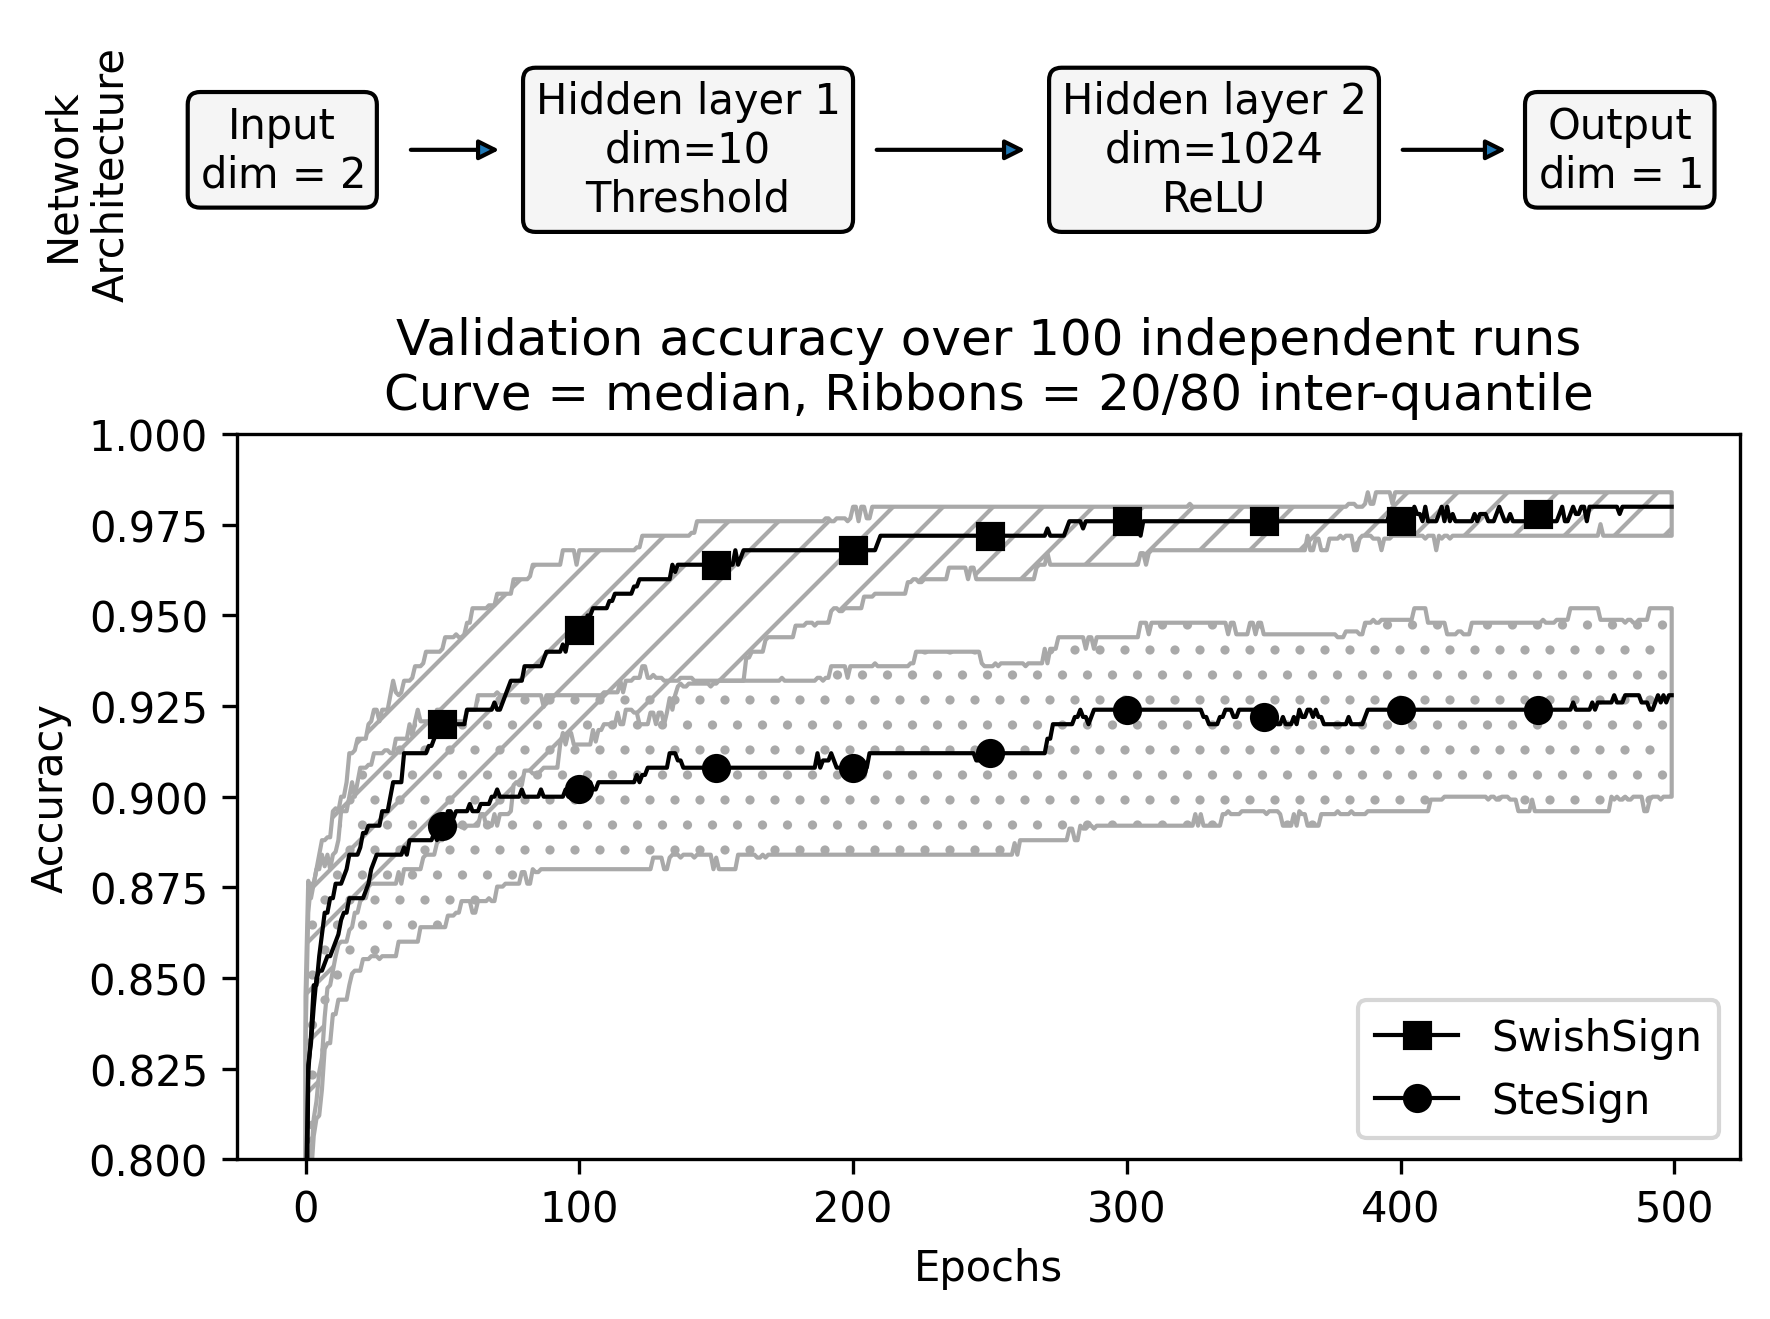

In [39]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig, figure
import numpy as np


# figure(figsize=(5, 3), dpi=80)

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(6,4.5),gridspec_kw={'height_ratios': [1, 3]},dpi=300)


c1_light = "darkgray"
c2_light = "darkgray"

c1_dark = "black"
c2_dark = "black"

ax = ax2

H = np.array(h1)
U = (1+round(100*np.max(H)))/100
med = np.median(H,axis=0)
q80 = np.quantile(H,0.8,axis=0)
q20 = np.quantile(H,0.2,axis=0)


ax.plot(med,color = c1_dark,lw=1,marker="s",markevery=50)
ax.fill_between(range(len(med)), q20, q80, color= c1_light, hatch="//",facecolors='none')

H = np.array(h2)
med = np.median(H,axis=0)
q80 = np.quantile(H,0.8,axis=0)
q20 = np.quantile(H,0.2,axis=0)
ax.plot(med,color = c2_dark, lw=1,marker="o",markevery=50)
# ax = plt.gca()
ax.fill_between(range(len(med)), q20, q80, color= c2_light,hatch="..",facecolors="none")

ax.set_ylim([0.8,U])
ax.legend(['SwishSign','SteSign'],loc='lower right')
ax.set_title('Validation accuracy over 100 independent runs\nCurve = median, Ribbons = 20/80 inter-quantile')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")



ax = ax1

centers = [(0.03,0.5),(0.3,0.5),(0.65,0.5),(0.92,0.5)]
radii = 1.5
texts = [
    '\n'.join(["Input",r"dim = $2$"]),
    '\n'.join(( "Hidden layer 1", r'dim=10', r'Threshold' )),
    '\n'.join(( "Hidden layer 2", r'dim=1024', r'ReLU' )),
    "\n".join(["Output", r"dim = $1$"]),
]


# Draw circles with text in the center

from matplotlib.patches import Polygon
props = dict(boxstyle='round', facecolor='whitesmoke')


# ax.axis('off')
ax.xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(ax.spines.values(), visible=False)
# remove ticks and labels for the left axis
ax.tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
ax.patch.set_visible(False)

ax.set_ylabel("Network\nArchitecture")
ax.yaxis.set_label_coords(-0.07,0.4)

for i, center in enumerate(centers):
    x, y = center
    ax.text(
        x, y,
        texts[i],
        transform=ax.transAxes,
        horizontalalignment="center",
        verticalalignment="center",
        bbox = props
    )

for i in range(len(centers)-1):
    print(i)

# Draw arrows connecting them

# https://e2eml.school/matplotlib_text.html#annotate
r = [0.08,0.12,0.12,0.07]
for i in range(len(r)-1):
    ax.annotate(
        "",
        (centers[i+1][0]-r[i+1] , centers[i+1][1]),
        (centers[i][0]+r[i] , centers[i][1]),
        transform=ax.transAxes,
        arrowprops=dict(arrowstyle = "-|>"),
    )


f.tight_layout()
savefig('figures/ste_vs_swish.eps',bbox_inches='tight')


plt.show()